In [1]:
# Add root folder to python path
import sys
import os
sys.path.append(os.path.dirname(os.getcwd()))

# Add some common packages
import numpy as np
import pandas as pd
import math
import scipy.stats as ss
from matplotlib import pyplot as plt
import seaborn as sns
from tqdm import tqdm

import plotly.express as px
from reliability.Fitters import Fit_Weibull_3P

In [2]:
# Set up the failure mode class
from pof.failure_mode import FailureMode
from pof.condition import Condition
from pof.task import *

fm = FailureMode(alpha=50, beta=1.5, gamma=20)

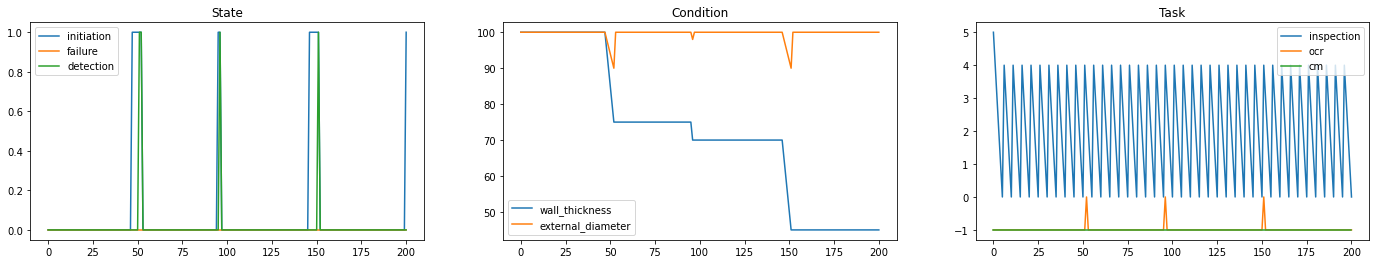

In [3]:
timeline = fm.sim_timeline(200, verbose=False)
fm.plot_timeline()

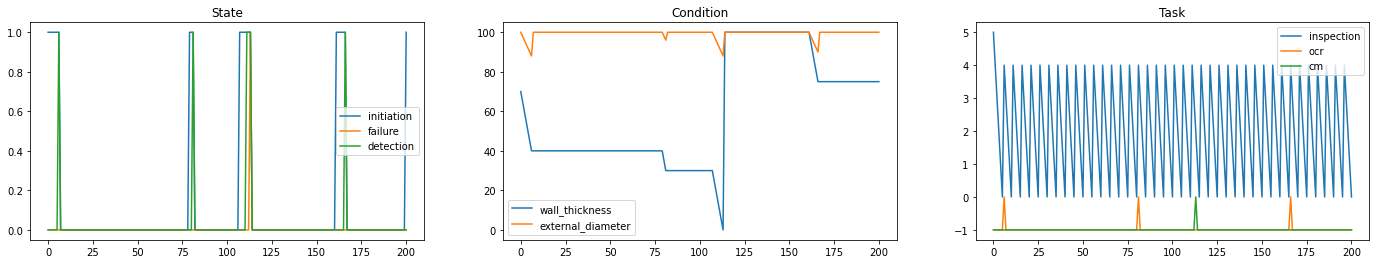

In [21]:
fm._initiated = True
fm.conditions['wall_thickness'].set_condition(70)
#fm.conditions['wall_thickness'].set_condition_profile()
fm.sim_timeline(200)
fm.plot_timeline()

In [23]:
fm = FailureMode(alpha=50, beta=1.5, gamma=20)

fm.conditions['wall_thickness'] = Condition(100, 0, 'linear', [-5])
fm.tasks['inspection'].p_effective = 1
fm.mc_timeline(t_end=200, n_iterations=1000)

df = fm.expected_cost_df()

fig = px.area(df, x="time", y="cost", color="task", title='Maintenance Strategy Costs')
fig.show()

100%|██████████| 1000/1000 [00:17<00:00, 56.53it/s]


In [27]:
fig = px.area(df, x="time", y="cost_cumulative", color="task", title='Maintenance Strategy Costs')
fig.show()

Results from Fit_Weibull_3P (95% CI):
           Point Estimate  Standard Error    Lower CI    Upper CI
Parameter                                                        
Alpha          202.249558       10.701670  182.325658  224.350670
Beta             2.765208        0.204174    2.392644    3.195786
Gamma           88.583379        9.576902   71.668345  109.490670
Log-Likelihood: -1227.4247539085625


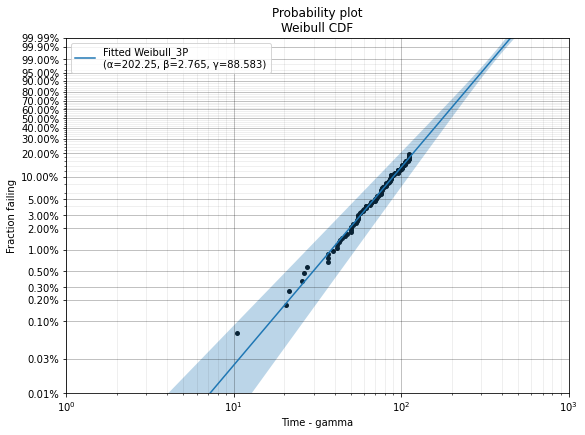

In [28]:
t_failures = []
for timeline in fm._timelines.values():
    t_failures = np.append(t_failures, np.argmax(timeline['failure']))

# Arange into failures and censored data
failures = t_failures[t_failures > 0]
censored = np.full(sum(t_failures==0), 200)

# Fit the Weibull
Fit_Weibull_3P(failures=failures, right_censored=censored)

Text(0.5, 1.0, 'failures')

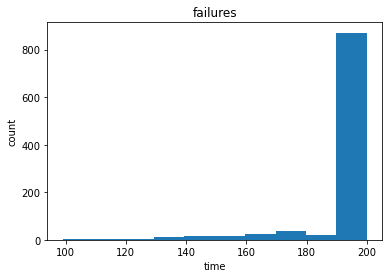

In [29]:
plt.hist(np.append(failures, censored))
plt.xlabel('time')
plt.ylabel('count')
plt.title('failures')

In [30]:
n_iterations = 1000
t_end = 200
t_start = 0

fm2 = FailureMode(alpha=50, beta=1.5, gamma=20)
del fm2.tasks['ocr']

for i in tqdm(range(n_iterations)):

    fm2._timelines[i] = fm2.sim_timeline(t_end=t_end, t_start=t_start)

100%|██████████| 1000/1000 [00:12<00:00, 77.22it/s]


Results from Fit_Weibull_3P (95% CI):
           Point Estimate  Standard Error   Lower CI   Upper CI
Parameter                                                      
Alpha           50.390236        1.131783  48.220099  52.658039
Beta             1.480747        0.036913   1.410138   1.554892
Gamma           24.475592        0.362255  23.775784  25.195998
Log-Likelihood: -4717.7642772218005


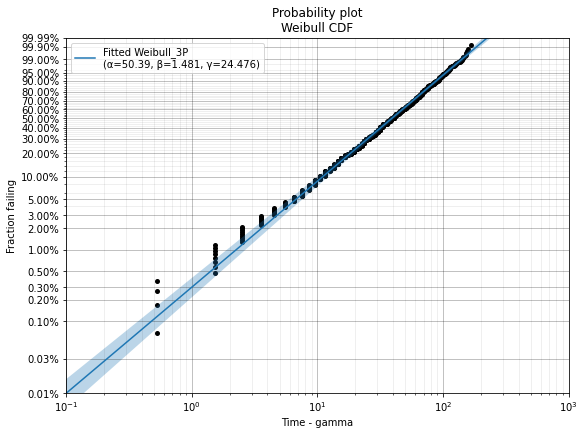

In [32]:
t_failures = []
for timeline in fm2._timelines.values():
    t_failures = np.append(t_failures, np.argmax(timeline['failure']))

# Arange into failures and censored data
failures = t_failures[t_failures > 0]
censored = np.full(sum(t_failures==0), 200)

# Fit the Weibull
Fit_Weibull_3P(failures=failures, right_censored=censored)

In [33]:
df2 = fm.mc_risk_df()

In [34]:
t_interval = dict()
risk = dict()
cost = dict()
fm.reset()

for i in range(1,10, 1):

    # Set t_interval
    fm.tasks['inspection'].t_interval = i
    
    fm.mc_timeline(t_end=100, n_iterations=1000)

    cost[i] = fm.expected_costs()
    cost[i]['inspection_interval'] = i

    # Reset fm

    fm.reset()

 71%|███████   | 706/1000 [00:07<00:03, 93.74it/s]


KeyboardInterrupt: 

In [16]:
df_plot = pd.DataFrame(cost).T

df_plot = pd.melt(df_plot, id_vars=['inspection_interval'], var_name = 'source', value_name = 'cost')

fig = px.line(df_plot, x="inspection_interval", y="cost", color='source', title='Risk v Cost at different Inspection Intervals')
fig.show()

In [18]:
# Dists

# Impacts



# Tasks
scheduled_inspection = Inspection(t_interval=10)

scheduled_inspection.set_params(
        t_interval = 5,
        t_delay = 20,
        p_effective = 0.9,
        state_triggers = dict(),

        condition_triggers = dict(
            wall_thickness = dict(
                lower = 0,
                upper = 90,
            ),
        ),

        state_impacts = dict( 
            detection = True,
        ),

        condition_impacts = dict(
            wall_thickness = dict(
                target = None,
                reduction_factor = 0,
                method = 'reduction_factor',
                axis = 'condition',
             ),
        ),
)



# Failure Modes
early_life = FailureMode(alpha=10000, beta=0.5, gamma=0)
random = FailureMode(alpha=100, beta=1, gamma=0)
slow_aging = FailureMode(alpha=100, beta=1.5, gamma=20)
fast_aging = FailureMode(alpha=50, beta=3, gamma=20)

fm_demo = slow_aging

fm_demo.set_conditions(dict(
    wall_thickness = Condition(100, 0, 'linear', [-2]),
    external_diameter = Condition(100, 0, 'linear', [-5]),
))

fm_demo.set_tasks(dict(
    inspection = scheduled_inspection,
    #ocr = OnConditionRepair(activity='on_condition_repair').set_default(),
    cm = ImmediateMaintenance(activity='cm').set_default(),
))


True

In [20]:
scheduled_inspection.__dict__

{'activity': 'inspection',
 'trigger': 'time',
 'trigger_comp': '1.1.2',
 '_package': NotImplemented,
 '_impacts_parent': NotImplemented,
 '_impacts_children': False,
 'cost': 100,
 'labour': 'trade',
 'spares': 'pole',
 'equipment': 'ewp',
 'consequence': <pof.consequence.Consequence at 0x21a342934c0>,
 'p_effective': 0.9,
 'time_triggers': {},
 'state_triggers': {},
 'condition_triggers': {},
 'time_imapcts': {},
 'state_impacts': {},
 'condition_impacts': {},
 'state': 'up',
 't_completion': [],
 '_timeline': NotImplemented,
 '_count_checked': NotImplemented,
 '_count_triggered': NotImplemented,
 '_count_completed': 0,
 't_delay': 20,
 't_interval': 5}

In [22]:
fm_demo.mc_timeline(1000)

df = fm_demo.expected_cost_df()

fig = px.area(df, x="time", y="cost_cumulative", color="task", title='Maintenance Strategy Costs')
fig.show()

100%|██████████| 100/100 [00:07<00:00, 12.91it/s]


In [26]:
np.arange(100,0, -1)

array([100,  99,  98,  97,  96,  95,  94,  93,  92,  91,  90,  89,  88,
        87,  86,  85,  84,  83,  82,  81,  80,  79,  78,  77,  76,  75,
        74,  73,  72,  71,  70,  69,  68,  67,  66,  65,  64,  63,  62,
        61,  60,  59,  58,  57,  56,  55,  54,  53,  52,  51,  50,  49,
        48,  47,  46,  45,  44,  43,  42,  41,  40,  39,  38,  37,  36,
        35,  34,  33,  32,  31,  30,  29,  28,  27,  26,  25,  24,  23,
        22,  21,  20,  19,  18,  17,  16,  15,  14,  13,  12,  11,  10,
         9,   8,   7,   6,   5,   4,   3,   2,   1])

In [40]:
np.full(10,True)

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

In [6]:
import numpy as np
timeline = dict(
    
            condition_1 = np.linspace(100, 0 , 101),
            condition_2 = np.linspace(200, 100 , 101),
            state_1 = np.concatenate((np.full(11,False), np.full(80, True), np.full(10, True))),
            state_2 = np.concatenate((np.full(21,False), np.full(60, True), np.full(20, True))),
        )

{'condition_1': array([100.,  99.,  98.,  97.,  96.,  95.,  94.,  93.,  92.,  91.,  90.,
         89.,  88.,  87.,  86.,  85.,  84.,  83.,  82.,  81.,  80.,  79.,
         78.,  77.,  76.,  75.,  74.,  73.,  72.,  71.,  70.,  69.,  68.,
         67.,  66.,  65.,  64.,  63.,  62.,  61.,  60.,  59.,  58.,  57.,
         56.,  55.,  54.,  53.,  52.,  51.,  50.,  49.,  48.,  47.,  46.,
         45.,  44.,  43.,  42.,  41.,  40.,  39.,  38.,  37.,  36.,  35.,
         34.,  33.,  32.,  31.,  30.,  29.,  28.,  27.,  26.,  25.,  24.,
         23.,  22.,  21.,  20.,  19.,  18.,  17.,  16.,  15.,  14.,  13.,
         12.,  11.,  10.,   9.,   8.,   7.,   6.,   5.,   4.,   3.,   2.,
          1.,   0.])}